In [1]:
import pandas as pd 
import numpy as np
from pprint import pprint
import warnings
import os

from Bio.PDB import PDBParser
from Bio.PDB.Residue import Residue
from src.pdb_to_dfs import ChainUnit, Chain, Structure

warnings.filterwarnings("ignore")


In [2]:
processed_folder = "./data/processed_pdbs"
pdb_name = "3H15.pdb"

pdb_file_path = os.path.join(processed_folder, pdb_name)
parser = PDBParser()

structure = parser.get_structure(pdb_name, pdb_file_path)
structure = structure[0]

In [3]:
# Get the chain
chain = structure["B"]


In [4]:
for res in chain.get_residues():
    print(ChainUnit(unit=res).is_fidelity_valid())

False
True
True


In [5]:
# Get the first residue
residue = chain.get_residues().__next__()
unit = ChainUnit(residue)
print(unit.__str__(include_coms=True))
pprint(unit.is_fidelity_valid(print_info=True))

Name of the unit: DC
ID of the unit: 9
Type of the unit: ssdna
Center of masses: None

Phosphate atoms: {'OP1', 'P', 'OP2'}
Sugar atoms: {"C4'", "O4'", "C1'", "C3'", "C5'", "O5'", "C2'"}
Present atoms: {'N4', 'C6', 'C4', 'C5', 'N3', "O3'", 'O2', 'N1', "C4'", "O4'", "C1'", "C3'", "C5'", 'C2', "O5'", "C2'"}
False


In [7]:
ch  = Chain(chain)
ch.create_dataframe()

,resname,id,phosphate_com,sugar_com,base_com
0,DC,10,"[31.668249130249023, 42.730255126953125, 8.845...","[31.704875946044922, 40.24812316894531, 12.269...","[35.83100509643555, 43.051666259765625, 10.074..."
1,DC,11,"[26.241750717163086, 45.03562545776367, 4.2733...","[23.18262481689453, 44.71412658691406, 0.45500...","[29.69499969482422, 42.822998046875, 5.7643332..."


In [2]:
def remove_outliers(df: pd.DataFrame, col: str, threshold: float = 3) -> pd.DataFrame:
    """
    Remove outliers from a dataframe using z-scores
    :param df: The dataframe
    :param col: The column name
    :return: The dataframe without outliers
    """

    # Get the z-scores
    z_scores = (df[col] - df[col].mean()) / df[col].std()

    # Get the rows that are not outliers
    not_outliers = z_scores.abs() < threshold

    # Return the dataframe without outliers
    return df[not_outliers]
    

## B-B-B Angle fitting

In [3]:
# Load the data
df_bbb = pd.read_csv("data/angles/bbb_angles.csv")
df_bbb.head()

,angle
0,122.263460
1,129.511417
2,94.663653
3,89.728993
4,93.611595


In [4]:
# Remove outliers
df_bbb = remove_outliers(df_bbb, "angle")

# Get the bins and the U values
bins, U = get_bins_U_norm(df_bbb)

# Fit the data
fit = fit_func(bins, U, maxfev=1000000)
popt2, popt4, popt6 = fit

In [5]:
# Plot the fits
plot_all_fits(bins, U, popt2, popt4, popt6)

# Get the best fit
best_fit = get_best_fit(bins, U, popt2, popt4, popt6, measure="mse")

In [6]:
best_fit

(array([-8.65707770e+00, -2.47652039e+01,  7.89367155e+00, -7.86780790e+03,
         2.37082285e+02,  1.28562383e+02,  2.95179967e+01, -1.69687102e+09,
         1.81268275e+08,  1.59537203e+01,  4.58953826e+01,  1.19165517e+01,
         1.59623624e+03,  5.71978560e+03, -3.04179543e+03,  2.38496589e+03,
         1.41037617e+02,  9.13175561e+01]),
 <function src.curve_fitting.func6(x: numpy.ndarray, a1: float, b1: float, c1: float, a2: float, b2: float, c2: float, a3: float, b3: float, c3: float, a4: float, b4: float, c4: float, a5: float, b5: float, c5: float, a6: float, b6: float, c6: float) -> numpy.ndarray>,
 0.043040328328185114)

## S-B-B Angle fitting

In [3]:
df = pd.read_csv("data/angles/sbb_angles.csv")
df.head()

,angle,residue
0,112.903277,GLU
1,146.635342,PHE
2,85.673875,LYS
3,123.167256,ILE
4,143.943048,LYS


In [4]:
df["residue"].unique()

array(['GLU', 'PHE', 'LYS', 'ILE', 'ARG', 'HIS', 'TRP', 'GLN', 'TYR',
       'MET'], dtype=object)

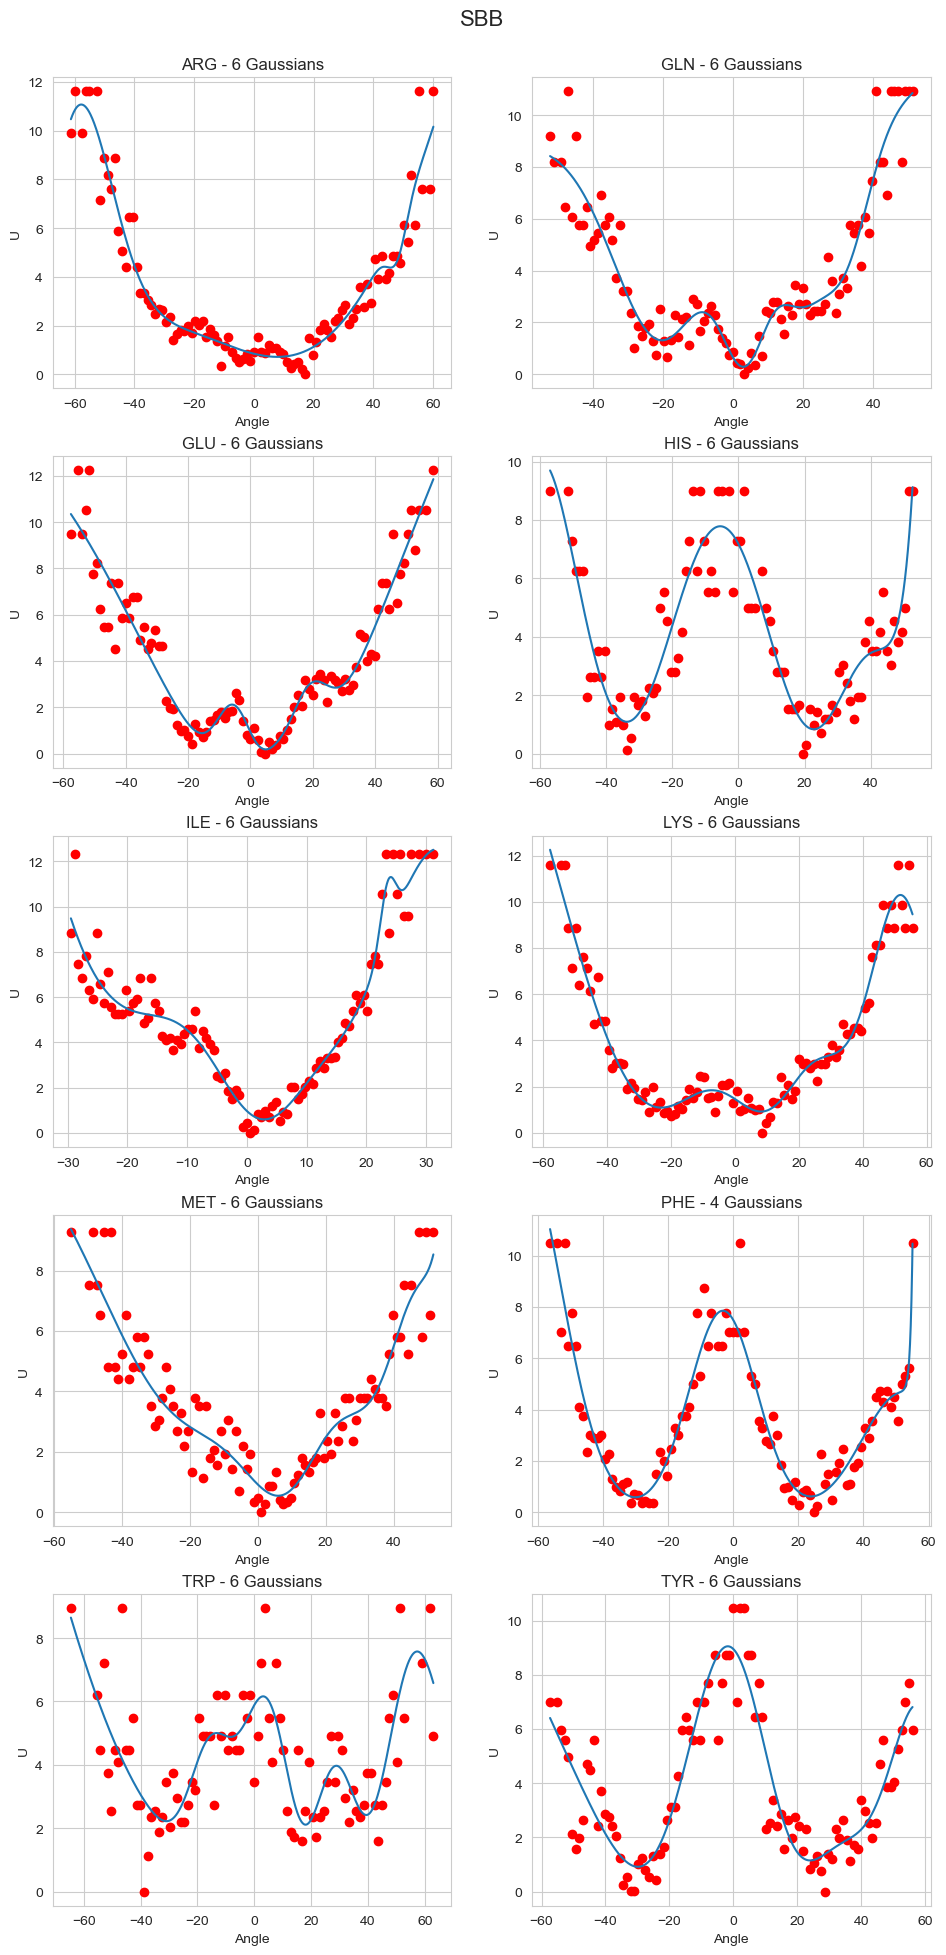

In [5]:
# Open a file to write the scores
f = open("data/scores_sbb.txt", "w")

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
fig.suptitle("SBB", fontsize=16)
fig.tight_layout(pad=3.0)

for i, data in enumerate(df.groupby("residue")):
    data = data[1]
    bin_centers, U, best_fit, func, score, num_gaussians = fit_df(data, bins=100)
    nrow = i // 2
    ncol = i % 2

    axs[nrow, ncol].plot(bin_centers, U, "ro")
    x = np.linspace(bin_centers.min(), bin_centers.max(), 1000)
    axs[nrow, ncol].plot(x, func(x, *best_fit))
    axs[nrow, ncol].set_title(f"{data['residue'].unique()[0]} - {num_gaussians} Gaussians")
    axs[nrow, ncol].set_xlabel("Angle")
    axs[nrow, ncol].set_ylabel("U")

    f.write(f"Residue: {data['residue'].unique()[0]}\n")
    f.write(f"Score: {score}\n")
    f.write(f"Number of Gaussians: {num_gaussians}\n")
    f.write(f"Best Fit: {best_fit}\n\n")

# Close the file
f.close()
plt.show()

# Save the figure
fig.savefig("data/sbb_fits.png")

## B-B-S Angle fitting

In [6]:
df = pd.read_csv("data/angles/bbs_angles.csv")
df.head()

,angle,residue
0,21.561235,PHE
1,22.128675,LYS
2,9.578320,ILE
3,21.444522,LYS
4,18.272978,LYS


In [7]:
df["residue"].unique()

array(['PHE', 'LYS', 'ILE', 'GLU', 'ARG', 'TRP', 'GLN', 'TYR', 'MET',
       'HIS'], dtype=object)

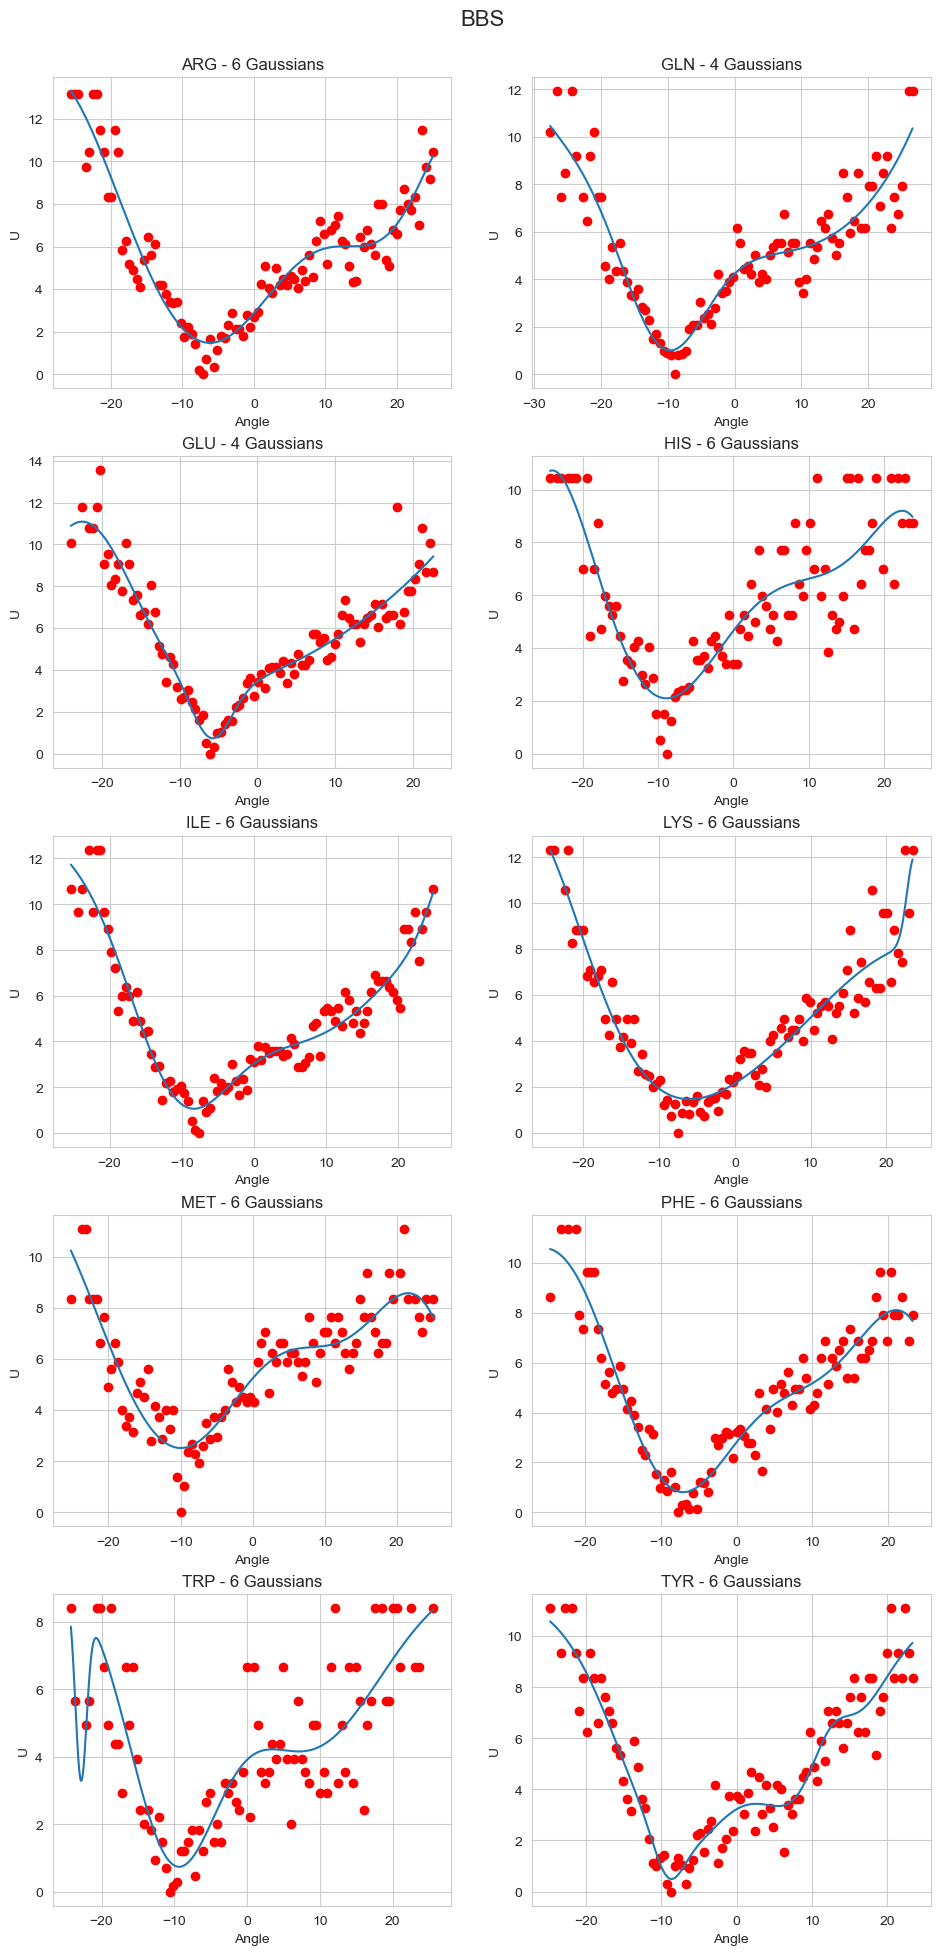

In [9]:
# Open a file to write the scores
f = open("data/scores_bbs.txt", "w")

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
fig.suptitle("BBS", fontsize=16)
fig.tight_layout(pad=3.0)

for i, data in enumerate(df.groupby("residue")):
    data = data[1]
    bin_centers, U, best_fit, func, score, num_gaussians = fit_df(data, bins=100)
    nrow = i // 2
    ncol = i % 2

    axs[nrow, ncol].plot(bin_centers, U, "ro")
    x = np.linspace(bin_centers.min(), bin_centers.max(), 1000)
    axs[nrow, ncol].plot(x, func(x, *best_fit))
    axs[nrow, ncol].set_title(f"{data['residue'].unique()[0]} - {num_gaussians} Gaussians")
    axs[nrow, ncol].set_xlabel("Angle")
    axs[nrow, ncol].set_ylabel("U")

    f.write(f"Residue: {data['residue'].unique()[0]}\n")
    f.write(f"Score: {score}\n")
    f.write(f"Number of Gaussians: {num_gaussians}\n")
    f.write(f"Best Fit: {best_fit}\n\n")

# Close the file
f.close()
plt.show()

# Save the figure
fig.savefig("data/bbs_fits.png")

In [1]:
# pip install -q transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

checkpoint = "bigcode/starcoder"
device = "cuda" # for GPU usage or "cpu" for CPU usage

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint, trust_remote_code=True).to(device)

inputs = tokenizer.encode("def print_hello_world():", return_tensors="pt").to(device)
outputs = model.generate(inputs)
print(tokenizer.decode(outputs[0]))

OSError: bigcode/starcoder is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

In [4]:
%pip install torch torchvision torchaudio

  Using cached torch-2.0.0-cp310-none-macosx_11_0_arm64.whl (55.8 MB)
  Using cached torchvision-0.15.1-cp310-cp310-macosx_11_0_arm64.whl (1.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 6.1 MB/s eta 0:00:0000:0100:01
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached MarkupSafe-2.1.2-cp310-cp310-macosx_10_9_universal2.whl (17 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch

# Define the input sequence
input_sequence = torch.randn(5, 3, 10)  # (sequence_length, batch_size, input_size)

# Define the RNN parameters
input_size = 10
hidden_size = 20

# Initialize the weights and biases for the input-to-hidden and hidden-to-hidden transformations
weights_ih = torch.randn(input_size, hidden_size)
weights_hh = torch.randn(hidden_size, hidden_size)
bias_ih = torch.randn(hidden_size)
bias_hh = torch.randn(hidden_size)

# Initialize the hidden state
hidden_state = torch.zeros(input_sequence.size(1), hidden_size)

# Perform the forward pass through the RNN
output_sequence = []
for i in range(input_sequence.size(0)):
    # Calculate the input-to-hidden and hidden-to-hidden transformations
    input_to_hidden = torch.matmul(input_sequence[i], weights_ih) + bias_ih
    hidden_to_hidden = torch.matmul(hidden_state, weights_hh) + bias_hh
    
    # Apply the nonlinearity (tanh) to the sum of the transformations
    hidden_state = torch.tanh(input_to_hidden + hidden_to_hidden)
    
    # Append the current hidden state to the output sequence
    output_sequence.append(hidden_state.unsqueeze(0))
    
# Concatenate the output sequence along the sequence length dimension
output_sequence = torch.cat(output_sequence, dim=0)

# Print the output and final hidden state
print('Output sequence:', output_sequence)
print('Final hidden state:', hidden_state)


Output sequence: tensor([[[-0.9983, -0.1020,  0.9796,  0.8955, -0.9651,  0.9588, -0.9297,
          -0.9176, -0.8507,  0.9989,  1.0000,  0.8338,  0.6313, -0.9993,
           0.4833,  0.8873, -0.7117,  1.0000, -0.4206, -0.9988],
         [-0.9495, -0.9823,  0.4039,  0.9995, -0.9943, -0.9718, -0.9939,
           1.0000,  1.0000, -1.0000, -0.9997, -0.9983,  1.0000,  1.0000,
           1.0000,  1.0000,  0.9906, -0.8386,  0.9998, -0.3861],
         [-0.9778,  0.3754, -0.9966,  0.0219, -0.9786,  0.9794, -0.6284,
          -0.7262, -0.9887, -0.8700, -0.9963,  0.9124,  0.8799,  0.9963,
           0.9988, -0.4924,  0.9991,  0.9023,  0.9510,  0.9959]],

        [[ 1.0000, -1.0000,  0.9852,  0.9249, -0.9998, -0.7862, -1.0000,
           0.4615, -0.9986,  0.7838, -0.9982,  0.9998, -0.9996,  0.9980,
           1.0000,  0.3919,  1.0000, -0.7145,  0.9565, -0.2097],
         [ 0.9999,  0.9992, -1.0000,  1.0000,  0.9929,  1.0000, -0.3171,
          -0.9492, -1.0000, -0.8302, -1.0000, -1.0000,  0.2454, 

In [4]:
input_sequence

tensor([[[-1.2311e+00,  5.7018e-01,  6.0148e-01,  1.7874e+00,  1.1612e+00,
           1.8493e-01, -6.1030e-01, -1.8242e-01,  7.1182e-01, -3.8912e-02],
         [ 1.1568e+00,  1.2655e+00,  1.6616e+00,  2.4573e-02, -2.1816e+00,
          -3.1512e-01, -2.3511e-01, -3.9302e-02, -1.5499e+00, -6.2155e-01],
         [-2.2806e-01,  1.7319e-01, -2.4536e-01, -9.1422e-01,  1.7773e-03,
           1.3372e-01, -5.7629e-02, -1.0315e+00,  1.0833e+00, -3.1534e-01]],

        [[ 5.4747e-01, -2.1283e-01, -1.2754e+00, -3.0443e-01,  3.0158e-01,
           1.3305e-01,  1.3369e+00,  6.6423e-01,  4.4948e-01, -1.6847e+00],
         [ 9.7569e-01, -3.6113e-01, -1.2652e-01, -5.7994e-01,  7.6736e-01,
           2.6005e-01,  1.5995e+00,  8.5415e-01, -1.2249e+00,  6.7340e-01],
         [-1.4194e+00, -3.6407e-01, -1.1924e-01,  1.7372e+00, -5.6428e-01,
           6.0694e-02, -4.5185e-01,  6.9958e-01, -2.6850e-01,  1.4596e+00]],

        [[-1.0732e+00, -7.7837e-01, -3.7686e-01,  1.2013e+00, -1.4127e+00,
           2.14

In [5]:
import torch

# Define the input sequences
input_sequence1 = torch.randn(5, 10)  # (sequence_length, input_size)
input_sequence2 = torch.randn(5, 10)  # (sequence_length, input_size)

# Define the RNN parameters
input_size = 10
hidden_size = 20

# Initialize the weights and biases for the input-to-hidden and hidden-to-hidden transformations
weights_ih = torch.randn(input_size, hidden_size, requires_grad=True)
weights_hh = torch.randn(hidden_size, hidden_size, requires_grad=True)
bias_ih = torch.randn(hidden_size, requires_grad=True)
bias_hh = torch.randn(hidden_size, requires_grad=True)

# Initialize the hidden states for both batches
hidden_state1 = torch.zeros(1, hidden_size)  # (num_layers * num_directions, batch_size, hidden_size)
hidden_state2 = torch.zeros(1, hidden_size)  # (num_layers * num_directions, batch_size, hidden_size)

# Perform the forward pass through the RNN for the first batch
output_sequence1 = []
for i in range(input_sequence1.size(0)):
    # Calculate the input-to-hidden and hidden-to-hidden transformations
    input_to_hidden = torch.matmul(input_sequence1[i], weights_ih) + bias_ih
    hidden_to_hidden = torch.matmul(hidden_state1[-1], weights_hh) + bias_hh
    
    # Apply the nonlinearity (tanh) to the sum of the transformations
    hidden_state1 = torch.tanh(input_to_hidden + hidden_to_hidden)
    
    # Append the current hidden state to the output sequence
    output_sequence1.append(hidden_state1)

# Perform the forward pass through the RNN for the second batch
output_sequence2 = []
for i in range(input_sequence2.size(0)):
    # Calculate the input-to-hidden and hidden-to-hidden transformations
    input_to_hidden = torch.matmul(input_sequence2[i], weights_ih) + bias_ih
    hidden_to_hidden = torch.matmul(hidden_state2[-1], weights_hh) + bias_hh
    
    # Apply the nonlinearity (tanh) to the sum of the transformations
    hidden_state2 = torch.tanh(input_to_hidden + hidden_to_hidden)
    
    # Append the current hidden state to the output sequence
    output_sequence2.append(hidden_state2)

# Concatenate the output sequences along the sequence length dimension
output_sequence1 = torch.stack(output_sequence1, dim=0)  # (sequence_length, hidden_size)
output_sequence2 = torch.stack(output_sequence2, dim=0)  # (sequence_length, hidden_size)

# Compute the loss for the first batch
loss1 = output_sequence1[-1].sum()

# Compute the gradients for the first batch
loss1.backward()

# Compute the loss for the second batch
loss2 = output_sequence2[-1].sum()

# Compute the gradients for the second batch
loss2.backward()

# Print the gradients for the weights and biases
print('Gradients for weights_ih:', weights_ih.grad)
print('Gradients for weights_hh:', weights_hh.grad)
print('Gradients for bias_ih:', bias_ih.grad)
print('Gradients for bias_hh:', bias_hh.grad)


RuntimeError: both arguments to matmul need to be at least 1D, but they are 0D and 2D

In [2]:
%pip install opencv-python -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Write code for ocr 

import pytesseract
from PIL import Image
import cv2
import os

# load the image and convert it to grayscale
image = cv2.imread("1.jpeg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Pass it to pytesseract for ocr
text = pytesseract.image_to_string(gray)
print(text)


S506 - Midterm
Spring 2023

Frist Name
Last Name
NJIT ID

Question 1
(a) Answer true or false

oH A= (1,2), Ba {et Ojthen ACB —  ifA={1) x {1,2}, B= (1h x {1

9 A= (1,2), B= (2922? 242-0} thenAeB 6 fA=(1} x {1,2}, B= {1} x (1

(b) what relation must hold between sets A and 22 in order for the given condition to be true?

o ANB =A. eAUB=A
eanu=0 * (an)

Question 2

Use proof by cases to prove that [2 + yl < l2l-+ I!

Relation AR is defined on the set of (1,2,):-+ ,7} such that (x,y) €R if 2-+y is an even number,
Check whether of not A is reflexive, symmetric, antisymmetric, and transitive, Provide the digraph,

B

then Ac B

